In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# FURTHER MODELLING

## train model on new feature set: combine hateful and abusive tweets, discard spam

In [2]:
# create according dataframe
df_tweets_us_upd = pd.read_csv('data/tweets_us_cleaned.csv')
df_tweets_us_bin = df_tweets_us_upd[df_tweets_us_upd['label'] != 'spam']
df_tweets_us_bin['label'].replace(to_replace='hateful', value='abusive', inplace=True)
df_tweets_us_bin

C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Unnamed: 0,tweet_id,coordinates,place_full_name,place_country_code,place_bb_coord,created_at,text,label,text_clean,lon,lat
0,0,847534226413105152,NaN,"Chicago, IL",US,"[[[-87.940033, 41.644102], [-87.523993, 41.644...",2017-03-30 19:41:20,Not having access to my money is fucking pissi...,abusive,"['access', 'money', 'fuck', 'piss']",-87.732013,41.833584
1,1,850793087391612928,NaN,"Chula Vista, CA",US,"[[[-117.117116, 32.582128], [-116.9278103, 32....",2017-04-08 19:30:53,I recorded a video and I look stupid as hell ...,abusive,"['record', 'video', 'look', 'stupid', 'hell', ...",-117.022463,32.633767
2,2,850211169662935040,NaN,"Yucaipa, CA",US,"[[[-117.126742, 34.003904], [-116.9750053, 34....",2017-04-07 04:58:33,"IM SO FUCKING PISSED!!! I HATE YOU TRUMP, I WA...",abusive,"['fucking', 'pissed', 'hate', 'trump', 'want',...",-117.050874,34.040645
3,3,850113727567409152,NaN,"Houston, TX",US,"[[[-95.823268, 29.522325], [-95.069705, 29.522...",2017-04-06 22:31:21,My 21st i wanna be in Miami getting so fucked ...,abusive,"['21st', 'wanna', 'miami', 'fucked']",-95.446487,29.838495
4,4,849043735468023808,NaN,"Dallas, TX",US,"[[[-96.977527, 32.620678], [-96.54598, 32.6206...",2017-04-03 23:39:35,Frank putting some idiot in his place. https:/...,abusive,"['frank', 'idiot', 'place']",-96.761753,32.819858
...,...,...,...,...,...,...,...,...,...,...,...,...
1194,1196,850125123520802816,NaN,"New Jersey, USA",US,"[[[-75.563587, 38.788657], [-73.88506, 38.7886...",2017-04-06 23:16:38,https://t.co/yeLgykzv8F via @youtubewhen is it...,abusive,"['fucking', 'face']",-74.724323,40.073041
1195,1197,850137245025804290,NaN,"Watervliet, NY",US,"[[[-73.719183, 42.705454], [-73.694662, 42.705...",2017-04-07 00:04:48,"@Enigma_7_ You fucked up not coming, they play...",abusive,"['fuck', 'come', 'play', 'sick']",-73.706922,42.721886
1196,1198,849087016490991617,NaN,"Orlando, FL",US,"[[[-81.507905, 28.3882177], [-81.2276403, 28.3...",2017-04-04 02:31:34,"Females hate liars but can\'t stand a ""let me ...",abusive,"['female', 'hate', 'liar', 'stand', 'let', 'fu...",-81.367773,28.501678
1197,1199,850036145522180097,NaN,"Maryland, USA",US,"[[[-79.487651, 37.886607], [-74.986286, 37.886...",2017-04-06 17:23:04,Can't fuck with these niggas they too fake all...,abusive,"['fuck', 'niggas', 'fake', 'hate']",-77.236969,38.805115


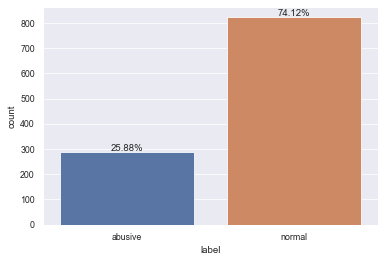

In [3]:
# count number of hate and normal tweets

# set theme temporarily
sns.set_theme(context='paper', style='darkgrid', font_scale=1)

graph = sns.countplot(x='label', data=df_tweets_us_bin)

# annotating percentage
total = float(len(df_tweets_us_bin['label']))
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 5, f'{np.round(height/total*100, 2)}%', ha="center")

fig = graph.get_figure()
fig.savefig('figs/countplot_labels_bin.png', dpi=400)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.compose import ColumnTransformer

# declare RandomState instance to obtain reproducible results
rng = np.random.RandomState(42)

# (cross validation) workflow: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# split data into training and testing sets
X_train, X_test, y_train, y_true = train_test_split(df_tweets_us_bin.drop(columns=['label']), df_tweets_us_bin['label'], test_size=0.2, random_state=rng)

# "spacy_tokenizer" took care of feature preprocessing, this function is needed as "TfidfVectorizer" applies default tokenizer otherwise!
# Applying scikit-learn TfidfVectorizer on tokenized text: https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
def identity_tokenizer(tweet):
    return tweet

In [5]:
# defining a pipeline combining preprocessing with random forest classifier
# applying "term frequency-inverse document frequency" (tf-idf) as text feature extractor
# following this approach: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
# reading about common pitfalls and recommended practices: https://scikit-learn.org/stable/common_pitfalls.html

preprocessor = ColumnTransformer(
    [
        ('tfidf', TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer, preprocessor=identity_tokenizer, token_pattern=None, norm='l1'), 'text_clean'),
        ('coord', 'passthrough', ['lon', 'lat'])
    ],
    remainder='drop', n_jobs=-1,
)

pipeline = Pipeline([
    ('preproc', preprocessor), 
    ('clf', RandomForestClassifier(random_state=rng, n_jobs=-1, bootstrap=True, verbose=0))
])

# setting parameters of the estimators in pipeline (can be accessed using "<estimator>__<parameter>")
params = {
    'preproc__tfidf__max_features': (500, 1000, None), # max number of features considered (ordered by term frequency), ~4000 in total
    'preproc__tfidf__binary': (True, False), # tf term in tf-idf is binary 
    'preproc__tfidf__use_idf': (False, True), # inverse-document-frequency reweighting

    # https://scikit-learn.org/stable/modules/ensemble.html#parameters
    'clf__n_estimators': (100, 500, 1000), # number of trees in forest
    'clf__max_features': (None, 'sqrt'), # size of the random subset of features to consider when splitting a node
    'clf__max_depth': (10, 30, None), # max depth of single tree
    'clf__min_samples_split': (2, 4), # min number of tweets (=samples) required to split internal node
    'clf__min_samples_leaf': (1, 3, 5) # min number of tweets required to be at leaf node
}

if __name__ == '__main__':
    # multiprocessing requires the fork to happen in a __main__ protected block

    # find the best parameters for feature extraction and classifier
    # https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=rng)
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=params,
        n_jobs=-1, verbose=1, error_score=0, # n_jobs is number of jobs to run in parallel (-1 means using all processors)
        cv=cv, scoring='f1_weighted'
    )
    # training model
    grid_search.fit(X_train, y_train)

    # THAT'S HOW TO ACCESS THE FUCKING MODEL!
    # http://apapiu.github.io/2016-08-04-tf_idf/
    model = grid_search.best_estimator_

    # print information about score and chosen parameters
    print('f1 score (weighted):',grid_search.best_score_) # FIXME!
    print('parameter set:')
    best_params = model.get_params()
    for param_name in sorted(params.keys()):
        print(f"\t{param_name}: {best_params[param_name]}")

    # predicting test data
    y_pred = grid_search.predict(X_test)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
f1 score (weighted): 0.8278529023142532
parameter set:
	clf__max_depth: 30
	clf__max_features: None
	clf__min_samples_leaf: 1
	clf__min_samples_split: 4
	clf__n_estimators: 100
	preproc__tfidf__binary: True
	preproc__tfidf__max_features: 500
	preproc__tfidf__use_idf: False


In [6]:
# save model with optimised parameters
import dill as pickle
pkl_filename = 'data/finalized_model_bin.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

              precision    recall  f1-score   support

     abusive       0.68      0.32      0.44        59
      normal       0.79      0.94      0.86       163

    accuracy                           0.78       222
   macro avg       0.74      0.63      0.65       222
weighted avg       0.76      0.78      0.75       222



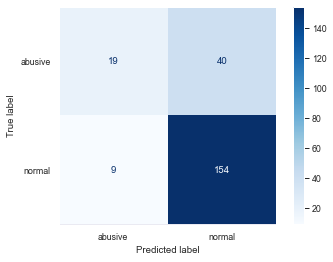

In [7]:
# classification report & confusion matrix
print(classification_report(y_true, y_pred))
fig, ax = plt.subplots(1, 1)
plot_confusion_matrix(model, X_test, y_true, cmap='Blues', ax=ax)
ax.grid(False)
fig.savefig('figs/confusion_matrix_bin.png', dpi=400)

,lat,lon,y_test,y_pred,prediction
963,36.060964,-115.135165,normal,normal,True
363,32.810012,-117.104989,normal,normal,True
56,39.284713,-76.620482,abusive,abusive,True
757,34.020789,-118.411907,normal,normal,True
785,25.712215,-80.313674,normal,normal,True
...,...,...,...,...,...
619,36.200008,-86.791549,normal,normal,True
590,42.794954,-71.225568,normal,normal,True
1054,29.838495,-95.446487,normal,normal,True
416,34.429885,-119.701636,normal,normal,True


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


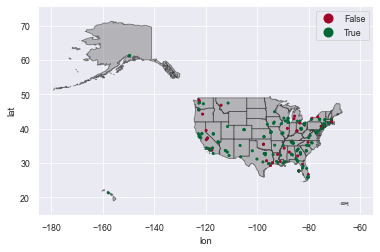

In [8]:
# plot map of wrongly predicted tweets
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point

# create dataset holding coord and labels
df_tweets_coord = X_test.loc[:, ['lat', 'lon']]
df_tweets_coord['y_test'] = y_true
df_tweets_coord['y_pred'] = y_pred

# adding column holding prediction result
df_tweets_coord['prediction'] = np.where(df_tweets_coord['y_test'] == df_tweets_coord['y_pred'], 'True', 'False')
display(df_tweets_coord)

# plotting

# importing shapefile of US (including states)
# downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
us_shapefile = gpd.read_file('data/cb_2020_us_state_5m/cb_2020_us_state_5m.shp')
# coordinate reference system
crs = {'init':'epsg:4326'}
# defining geometry
geometry = [ Point(xy) for xy in zip(df_tweets_coord['lon'], df_tweets_coord['lat']) ]
# building geopandas dataframe
df_geo = gpd.GeoDataFrame(df_tweets_coord, crs=crs, geometry=geometry)

ax = us_shapefile.plot(facecolor='Grey', edgecolor='k', alpha=0.5, linewidth=0.8)
df_geo.plot(ax=ax, column='prediction', legend=True, cmap='RdYlGn', categorical=True, markersize=5)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_xlim(left=-185, right=-55)
ax.set_ylim(bottom=15)
ax.grid('off')
plt.savefig('figs/US_tweet_map_prediction_bin.png', dpi=400)

## new feature set: just using coordinates as features, discard all text

In [9]:
# (cross validation) workflow: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# split data into training and testing sets
X_train, X_test, y_train, y_true = train_test_split(df_tweets_us_upd.drop(columns=['label']), df_tweets_us_upd['label'], test_size=0.2, random_state=rng)

In [10]:
# defining a pipeline combining preprocessing with random forest classifier
# applying "term frequency-inverse document frequency" (tf-idf) as text feature extractor
# following this approach: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
# reading about common pitfalls and recommended practices: https://scikit-learn.org/stable/common_pitfalls.html

preprocessor = ColumnTransformer(
    [
        #('tfidf', TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer, preprocessor=identity_tokenizer, token_pattern=None, norm='l1'), 'text_clean'),
        ('coord', 'passthrough', ['lon', 'lat'])
    ],
    remainder='drop', n_jobs=-1,
)

pipeline = Pipeline([
    ('preproc', preprocessor), 
    ('clf', RandomForestClassifier(random_state=rng, n_jobs=-1, bootstrap=True, verbose=0))
])

# setting parameters of the estimators in pipeline (can be accessed using "<estimator>__<parameter>")
params = {
    #'preproc__tfidf__max_features': (500, 1000, None), # max number of features considered (ordered by term frequency), ~4000 in total
    #'preproc__tfidf__binary': (True, False), # tf term in tf-idf is binary 
    #'preproc__tfidf__use_idf': (False, True), # inverse-document-frequency reweighting

    # https://scikit-learn.org/stable/modules/ensemble.html#parameters
    'clf__n_estimators': (100, 500, 1000), # number of trees in forest
    'clf__max_features': (None, 'sqrt'), # size of the random subset of features to consider when splitting a node
    'clf__max_depth': (10, 30, None), # max depth of single tree
    'clf__min_samples_split': (2, 4), # min number of tweets (=samples) required to split internal node
    'clf__min_samples_leaf': (1, 3, 5) # min number of tweets required to be at leaf node
}

if __name__ == '__main__':
    # multiprocessing requires the fork to happen in a __main__ protected block

    # find the best parameters for feature extraction and classifier
    # https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=rng)
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=params,
        n_jobs=-1, verbose=1, error_score=0, # n_jobs is number of jobs to run in parallel (-1 means using all processors)
        cv=cv, scoring='f1_weighted'
    )
    # training model
    grid_search.fit(X_train, y_train)

    # THAT'S HOW TO ACCESS THE FUCKING MODEL!
    # http://apapiu.github.io/2016-08-04-tf_idf/
    model = grid_search.best_estimator_

    # print information about score and chosen parameters
    print('f1 score (weighted):',grid_search.best_score_) # FIXME!
    print('parameter set:')
    best_params = model.get_params()
    for param_name in sorted(params.keys()):
        print(f"\t{param_name}: {best_params[param_name]}")

    # predicting test data
    y_pred = grid_search.predict(X_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
f1 score (weighted): 0.5838842817203634
parameter set:
	clf__max_depth: 10
	clf__max_features: sqrt
	clf__min_samples_leaf: 1
	clf__min_samples_split: 4
	clf__n_estimators: 1000


In [11]:
# save model with optimised parameters
import dill as pickle
pkl_filename = 'data/finalized_model_coord.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

     abusive       0.56      0.12      0.19        43
     hateful       0.00      0.00      0.00        17
      normal       0.67      0.95      0.79       160
        spam       0.00      0.00      0.00        20

    accuracy                           0.65       240
   macro avg       0.31      0.27      0.24       240
weighted avg       0.55      0.65      0.56       240



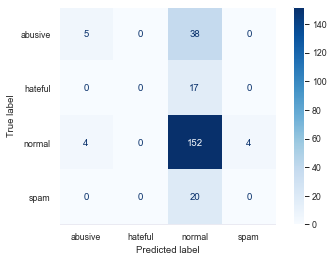

In [12]:
# classification report & confusion matrix
print(classification_report(y_true, y_pred))
fig, ax = plt.subplots(1, 1)
plot_confusion_matrix(model, X_test, y_true, cmap='Blues', ax=ax)
ax.grid(False)
fig.savefig('figs/confusion_matrix_coord.png', dpi=400)